# Telco Customer Churn – ML Case Study (Champion: Gradient Boosting)
**Author:** Anton Dimitrov  
**Objective:** Business-aware modeling & actionable churn insights


# Case Study: Customer Churn Prediction for Telco telecom
### Business Objective
The aim of this project is to **predict customers at high risk of churn** and derive actionable retention strategies that **reduce retention costs** and **improve engagement efficiency**.


## Problem Definition

This case study focuses on **customer churn reduction for XYZ Telecom** using data-driven strategies.

### Business Goal:
- Identify customers likely to churn
- Build a predictive ML solution
- Provide actionable retention strategies
- Support stakeholders with explainable analytics

### Technical Objective:
We formulate this as a **binary classification problem**, where:  
- **Churn = 1** = customer left the service  
- **Churn = 0** = customer is retained

Our solution prioritizes:
✔ Reproducibility  
✔ Business-aware preprocessing  
✔ Strong predictive performance  
✔ Clear stakeholder communication


In [54]:
# loading libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import scipy.stats as ss

warnings.simplefilter('ignore')

In [55]:
# load raw data
data = pd.read_csv('raw_data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Dataset Overview

The dataset is sourced from **Kaggle – Telco Customer Churn** and contains customer demographics, account characteristics, service usage, and billing details.

### Structure:
- Each row represents **one telecom subscriber**
- Historical usage and billing behavior
- Mix of **categorical and numerical predictors**
- Explicit business churn labels (Yes/No)

### Initial Inspection:
We load the raw file directly from the **project folder**, ensuring full reproducibility for any evaluator or stakeholder running this notebook.


### DATA CLEANING

In [3]:
# drop duplicates
data_shape_before_drop_dupl = data.shape
data_2 = data.copy()
data_2 = data_2.drop_duplicates()

if data_shape_before_drop_dupl[0] == data_2.shape[0]:
    print('There are not duplicates')
else:
    dups = data_shape_before_drop_dupl[0] - data_2.shape[0]
    print(f'There are {dups} duplicates')

data_2.columns = data_2.columns.str.lower().str.strip()
print(data_2.columns)

There are not duplicates
Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')


## Dataset Overview (Business Context)

- **Industry:** Telecom (Customer Retention)
- **Unit of analysis:** Individual customer
- **Target:** 'Churn' → if the customer has left the service (Yes/No)
- **Data provided:** Demographics, account information, service usage flags, and billing history.
- **Specific observation:** 'TotalCharges' is missing only for customers with 'tenure = 0', meaning these are **fresh clients without billing history yet**.

This section documents the dataset understanding prior to preprocessing, EDA and modeling.


In [4]:
# describtion about train dataset
print(data_2.describe(include='all'))
# column types
print(data_2.dtypes)

        customerid gender  seniorcitizen partner dependents       tenure  \
count         7043   7043    7043.000000    7043       7043  7043.000000   
unique        7043      2            NaN       2          2          NaN   
top     7590-VHVEG   Male            NaN      No         No          NaN   
freq             1   3555            NaN    3641       4933          NaN   
mean           NaN    NaN       0.162147     NaN        NaN    32.371149   
std            NaN    NaN       0.368612     NaN        NaN    24.559481   
min            NaN    NaN       0.000000     NaN        NaN     0.000000   
25%            NaN    NaN       0.000000     NaN        NaN     9.000000   
50%            NaN    NaN       0.000000     NaN        NaN    29.000000   
75%            NaN    NaN       0.000000     NaN        NaN    55.000000   
max            NaN    NaN       1.000000     NaN        NaN    72.000000   

       phoneservice multiplelines internetservice onlinesecurity  ...  \
count         

In [5]:
# totalcharges is object (convert it to numeric)
data_2["totalcharges"] = data_2["totalcharges"].apply(pd.to_numeric, errors='coerce')

In [6]:
# check for null values
data_2.isna().sum()

customerid           0
gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

In [7]:
# all Nans of totalcharges has zero tenure. That's why we can assume totalcharges = monthlycharges. They're fresh customers.
data_2[data_2['totalcharges'].isnull()]

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [8]:
# check totalcharges values where tenure = 0 
test = data_2[data_2['tenure'] == 0]
test.head(20)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [9]:
# Replace missing totalcharges for tenure == 0 with 0 (fresh customers, not yet billed)
data_2.loc[data_2['tenure'] == 0, 'totalcharges'] = 0

In [10]:
# drop customerid (not needed)
data_2 = data_2.drop(columns=['customerid'])

In [11]:
# check churn distribution
print(data_2['churn'].value_counts())

churn
No     5174
Yes    1869
Name: count, dtype: int64


# Exploratory Data Analysis (EDA)

We now explore the relationship between customer attributes and churn behavior to support retention strategies.  
EDA is performed **before encoding**, to maintain business interpretability of category labels.


In [12]:
data_2.describe()

,seniorcitizen,tenure,monthlycharges,totalcharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [13]:
# detect categorical object columns
cat_cols = [col for col in data_2.select_dtypes(include="object").columns.tolist() if col != "churn"] 
cat_cols

['gender',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod']

In [16]:
# define num feature plot function
def num_plot_dist(df, num_features):
    fig, axes = plt.subplots(len(num_features),2,figsize=(15, len(num_features)*5))
    if len(num_features) == 1:
        axes=[axes]
    for i, column in enumerate(num_features):
        sns.histplot(data=df, x=column, ax=axes[i][0], kde=True, palette='Blues')
        axes[i][0].set_title(f"Histogram for {column}")

        sns.boxplot(data=df, x=column, ax=axes[i][1], palette='Blues')
        axes[i][1].set_title(f"Box Plot for {column}")

    plt.tight_layout()
    plt.show()


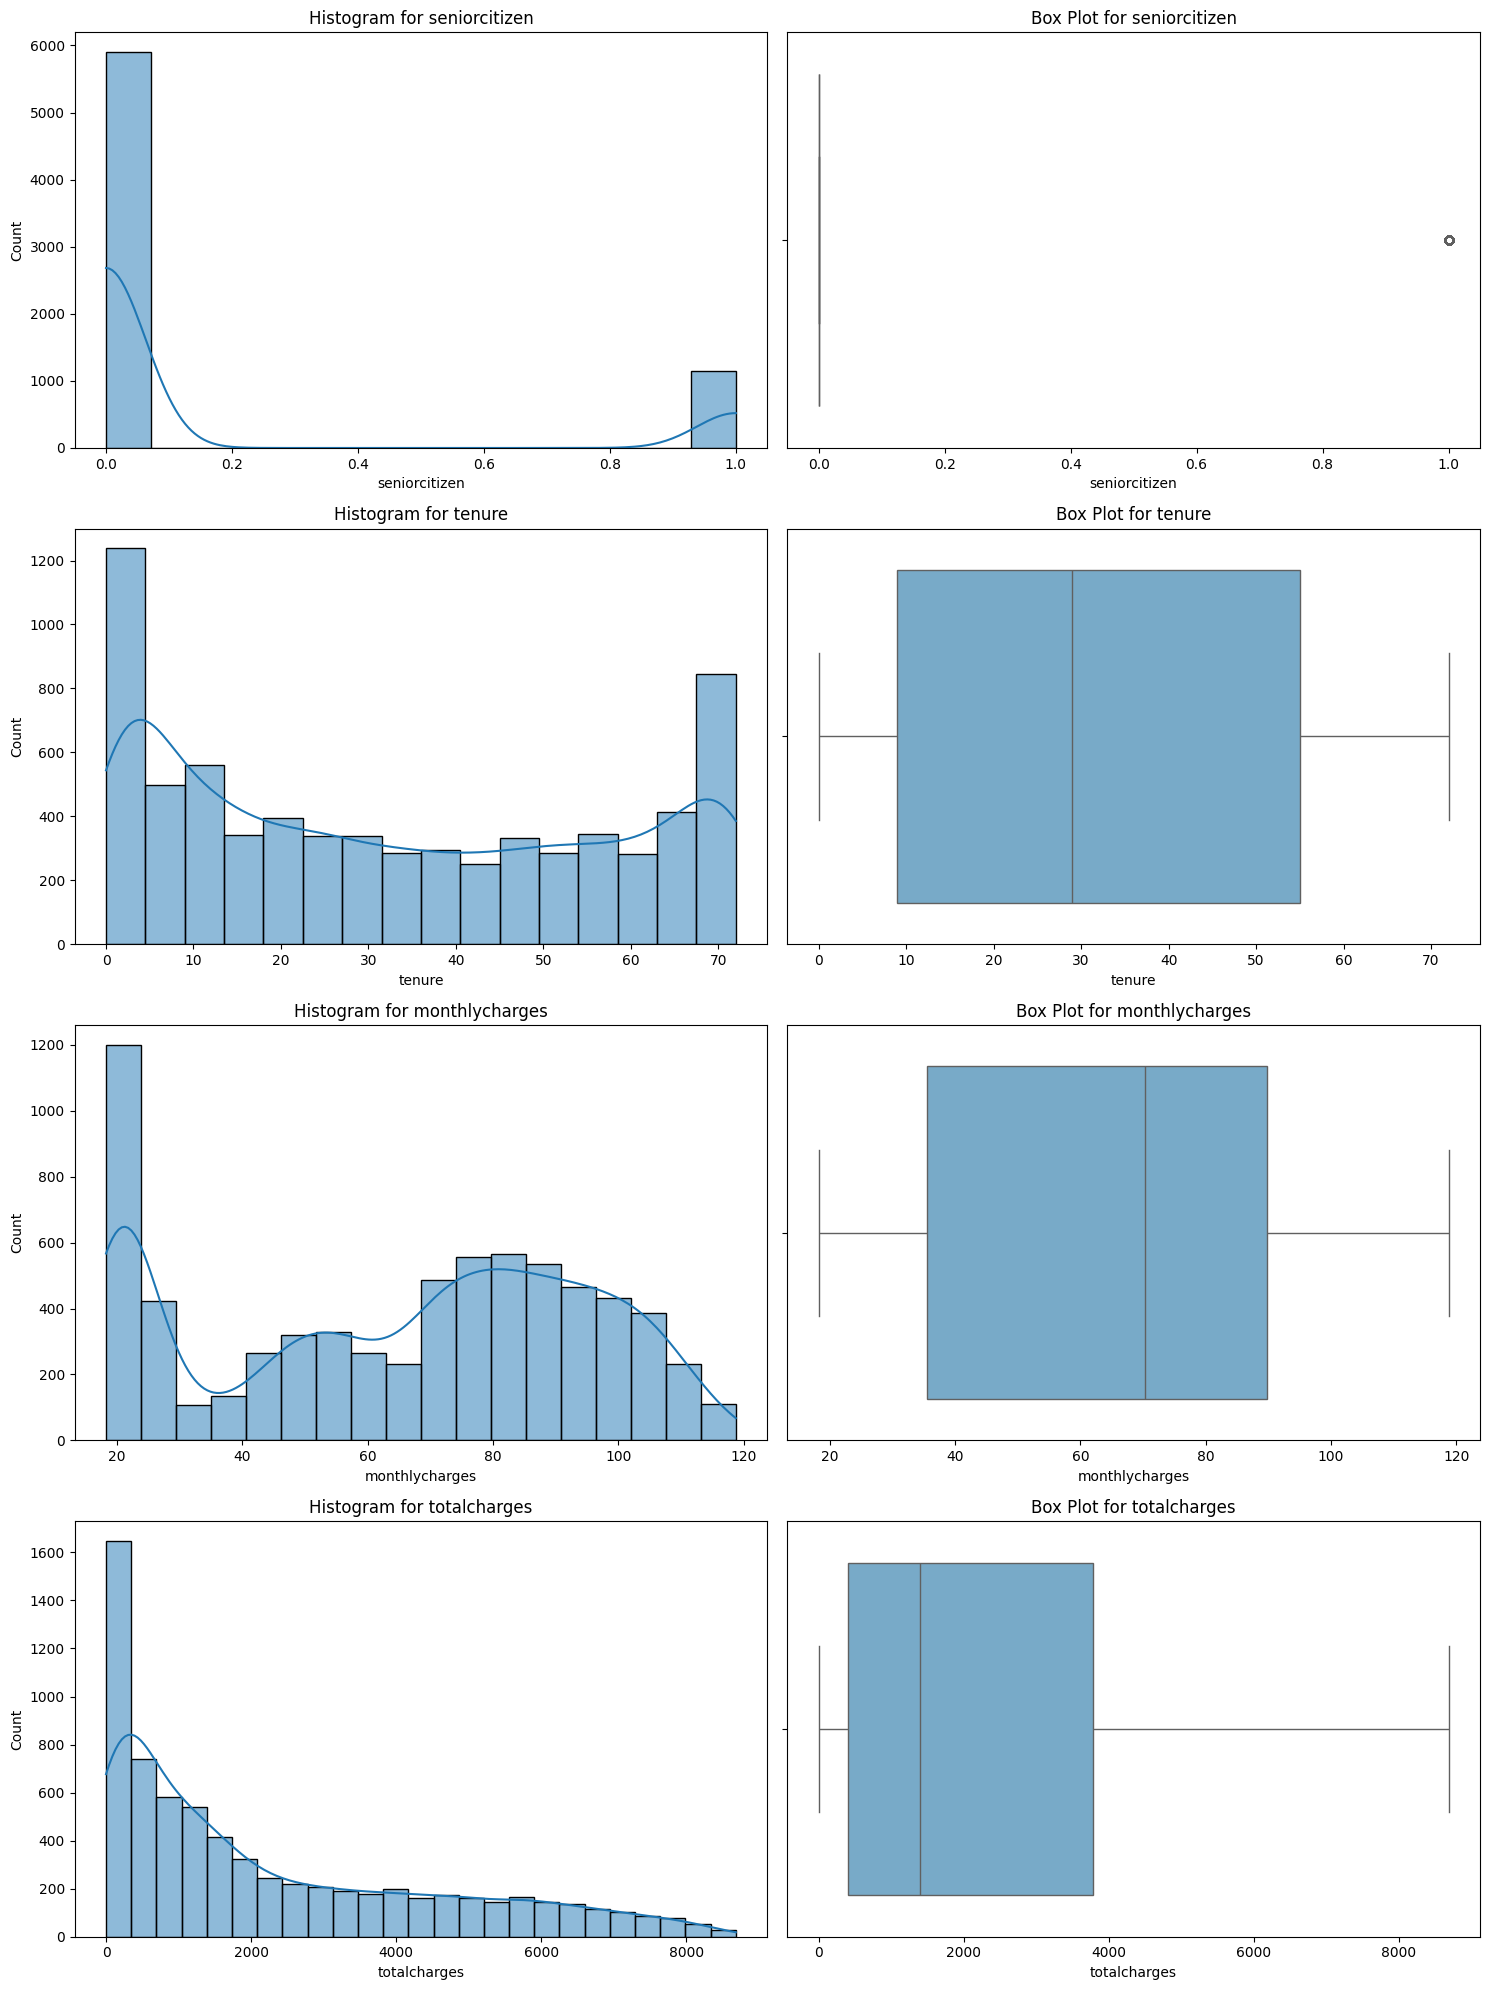

In [17]:
# get numeric variables
num_features = data_2.select_dtypes(include=["number"]).columns.tolist()

num_plot_dist(data_2, num_features)

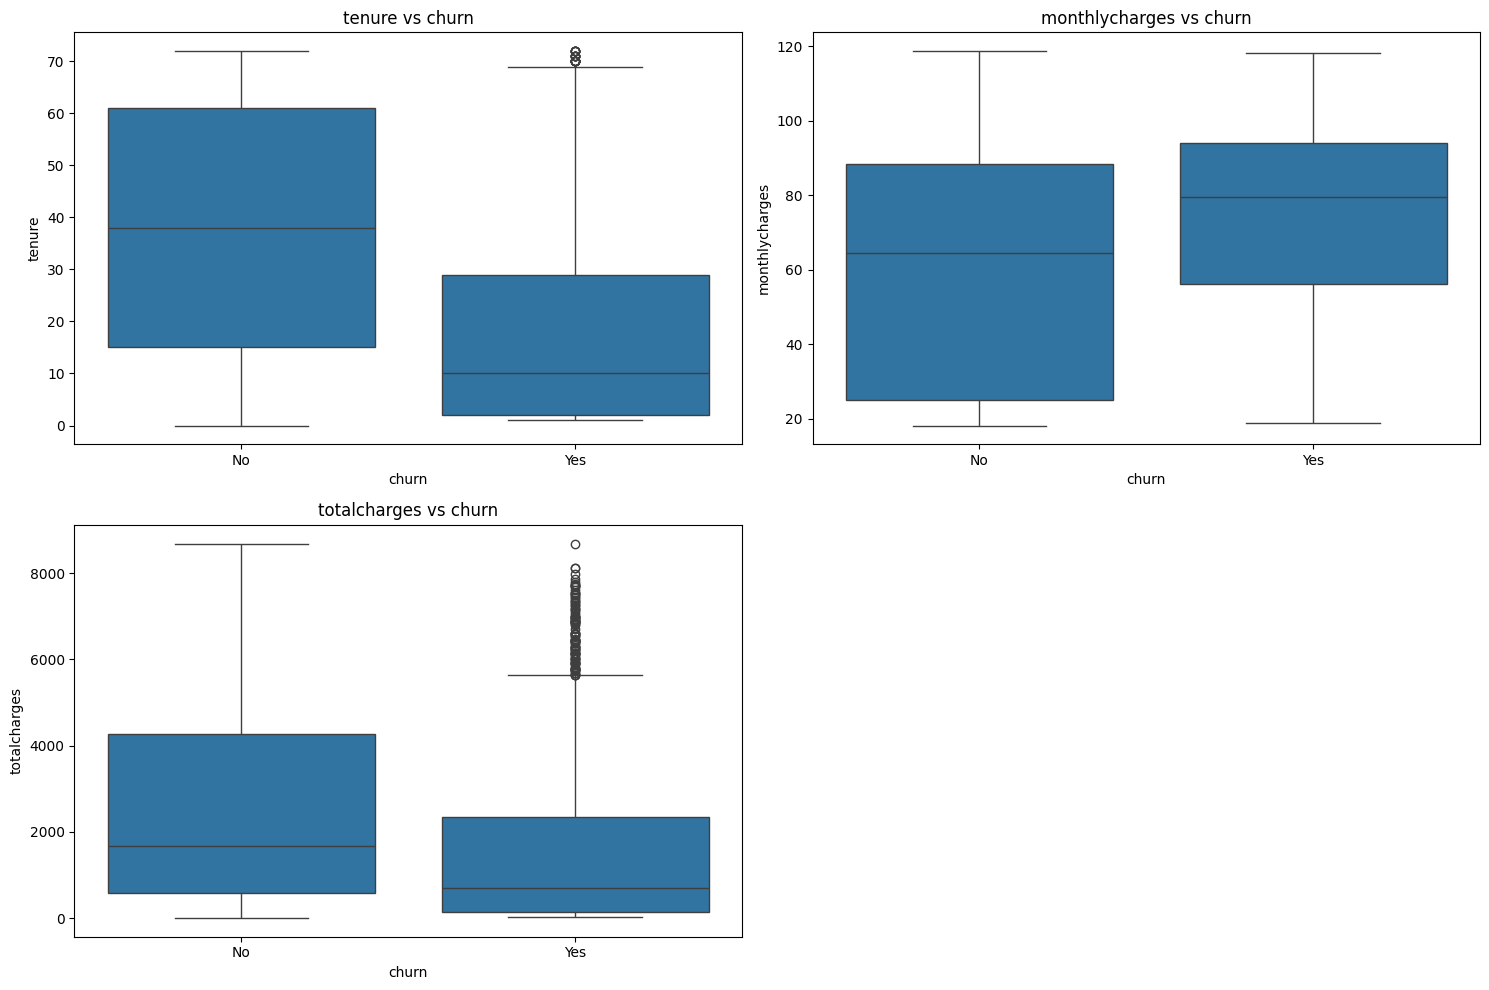

In [19]:
# bivariate 
def plot_bivariate_num(df, target, num_features):
    num_plots = len(num_features)
    num_rows = (num_plots + 1) // 2

    fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))
    axes = axes.flatten()

    for i, column in enumerate(num_features):
        sns.boxplot(x=df[target], y=df[column], ax=axes[i], data=df)
        axes[i].set_title(f"{column} vs {target}")
        axes[i].set_xlabel(target)

    # Hide unused plots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# calling the function
plot_bivariate_num(data_2, "churn", ["tenure", "monthlycharges", "totalcharges"])


In [ ]:
# categorical variables viz
def plot_cat_churn_pair(df, target, cat_cols):
    for feature in cat_cols:
     
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # distribution 
        counts = df[feature].value_counts(dropna=False)
        counts.plot(kind='bar', ax=axes[0])  
        axes[0].set_title(f"{feature} distribution")
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel("count")
        axes[0].tick_params(axis='x', rotation=90)

        # feature vs churn 
        sns.countplot(x=feature, hue=target, data=df, ax=axes[1])
        axes[1].set_title(f"{feature} vs {target}")
        axes[1].set_xlabel(feature)
        axes[1].set_ylabel("count")
        axes[1].tick_params(axis='x', rotation=90)

        plt.tight_layout()
        plt.show()


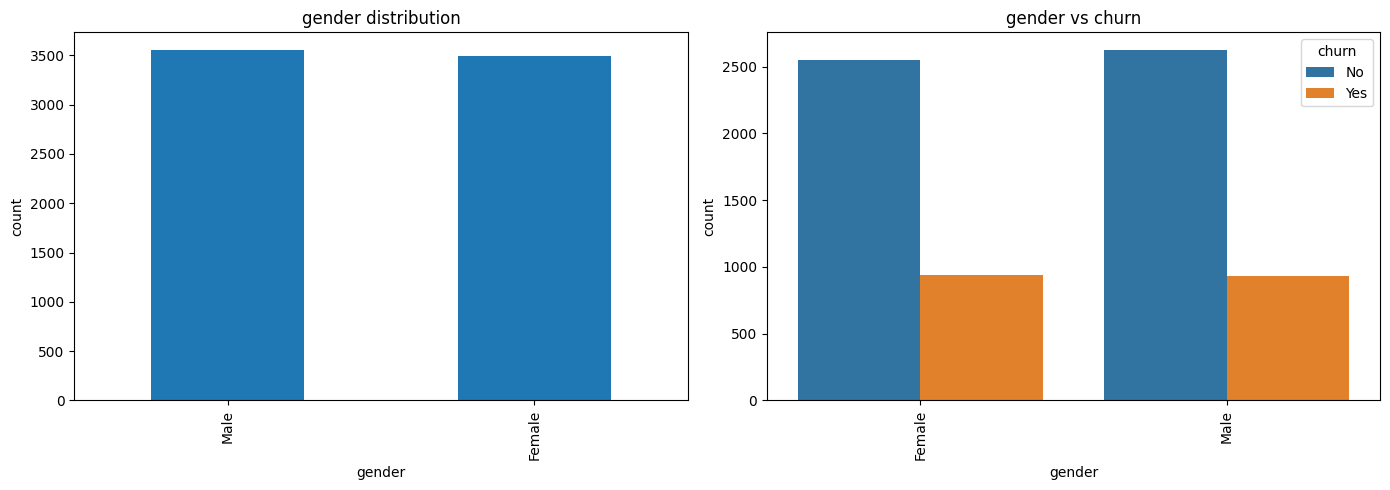

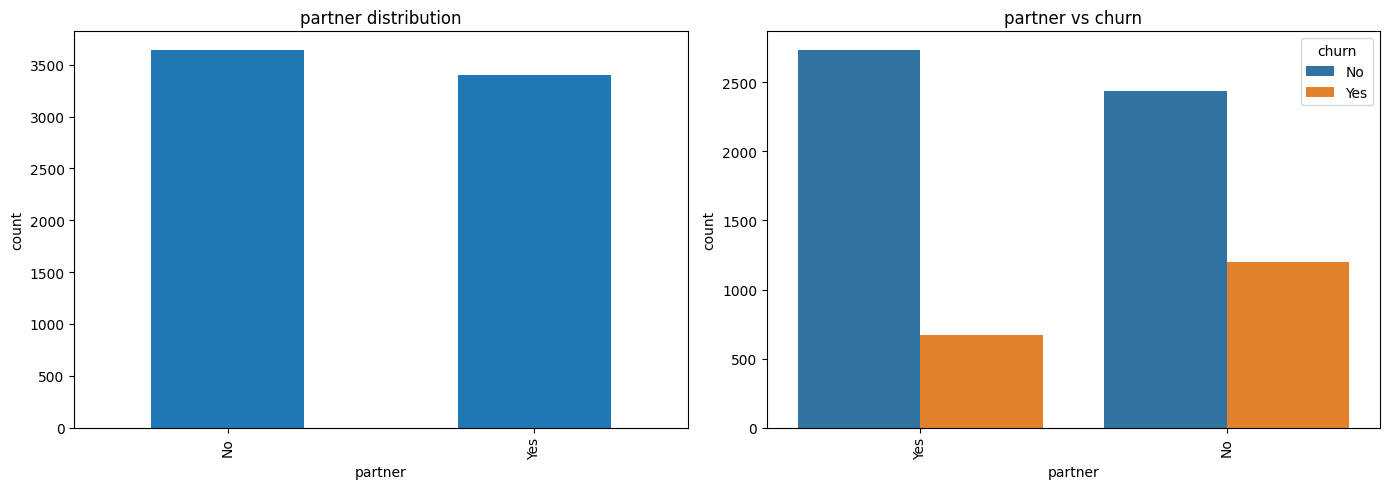

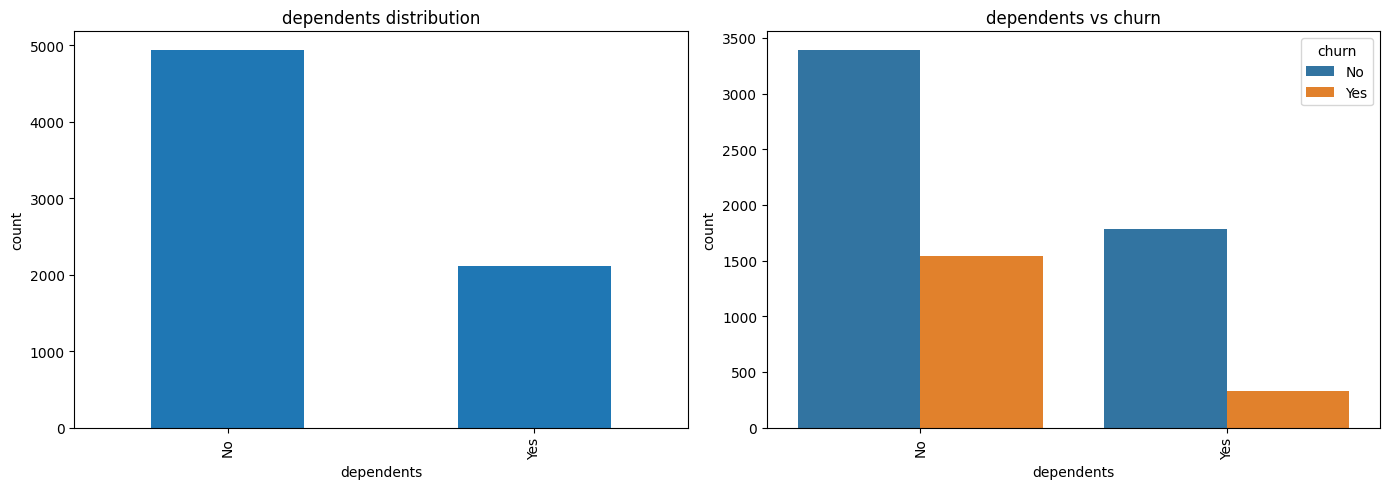

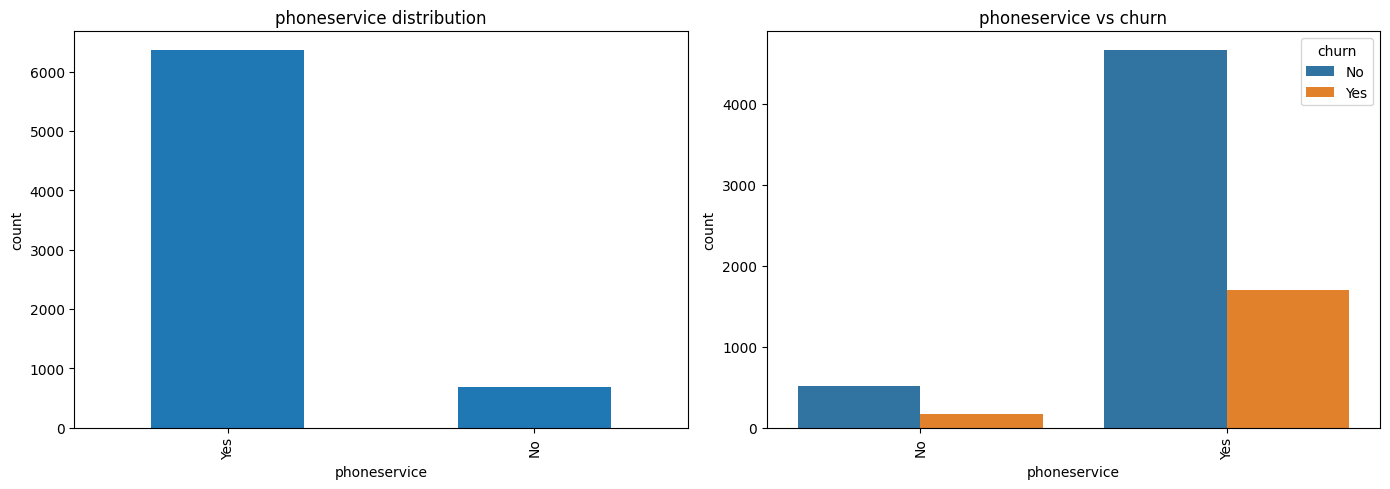

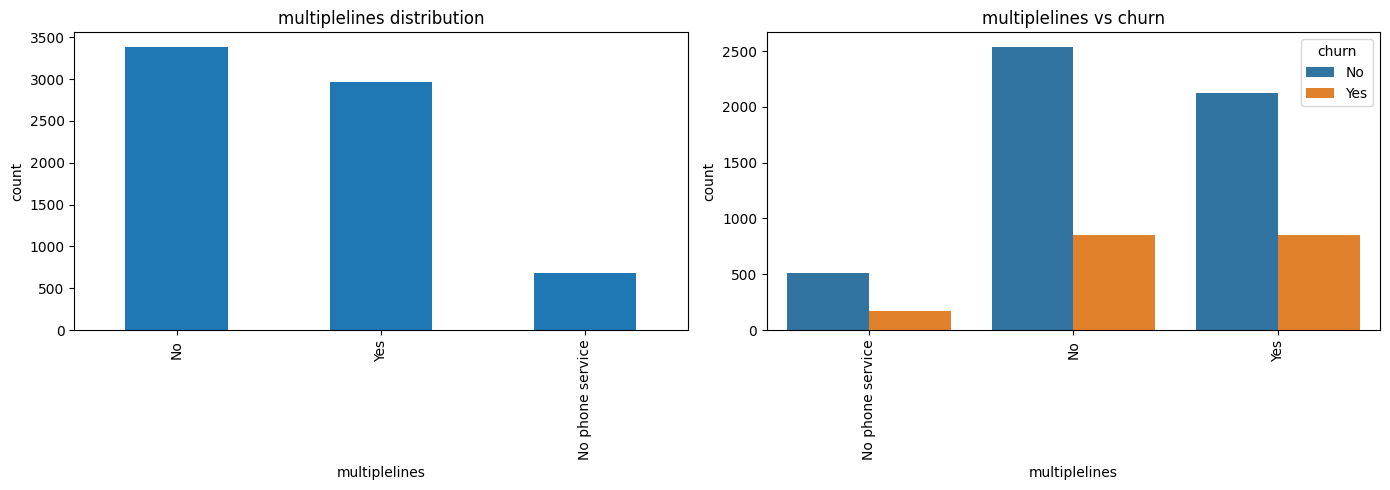

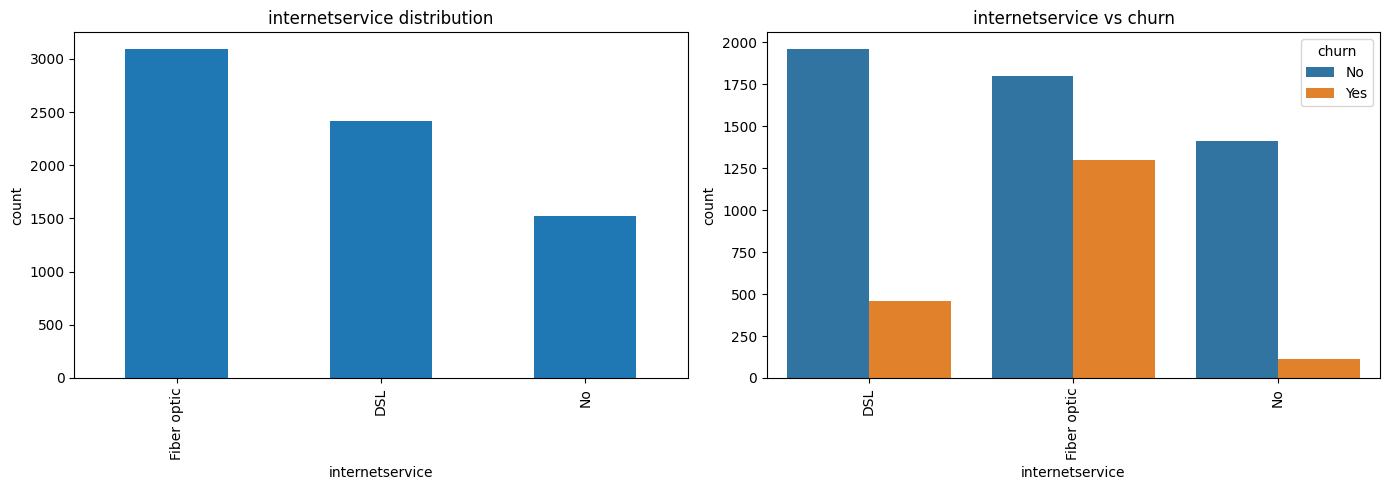

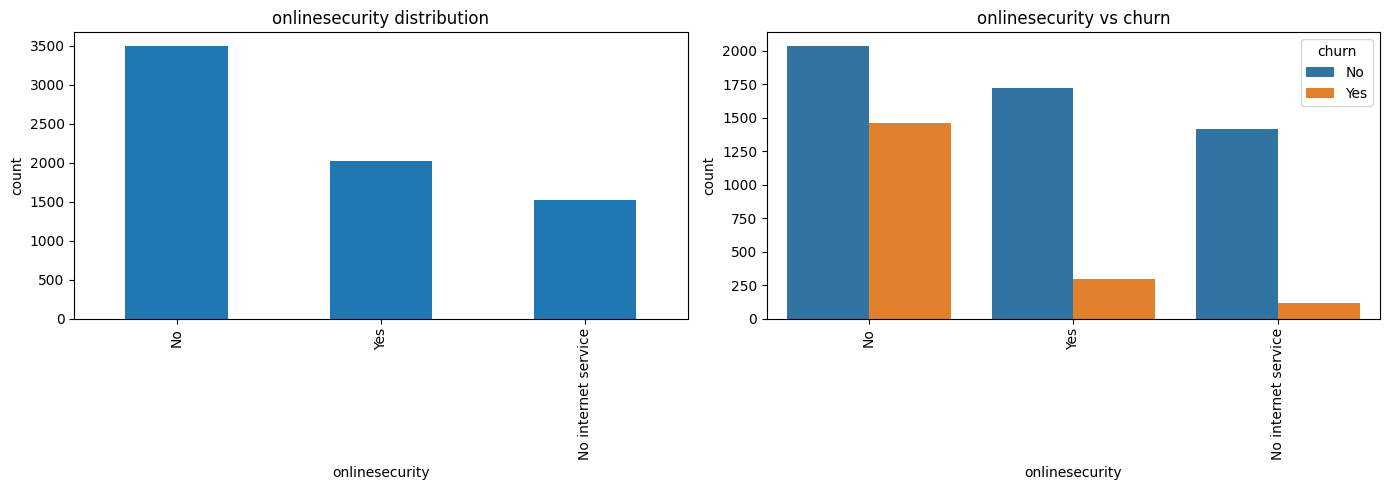

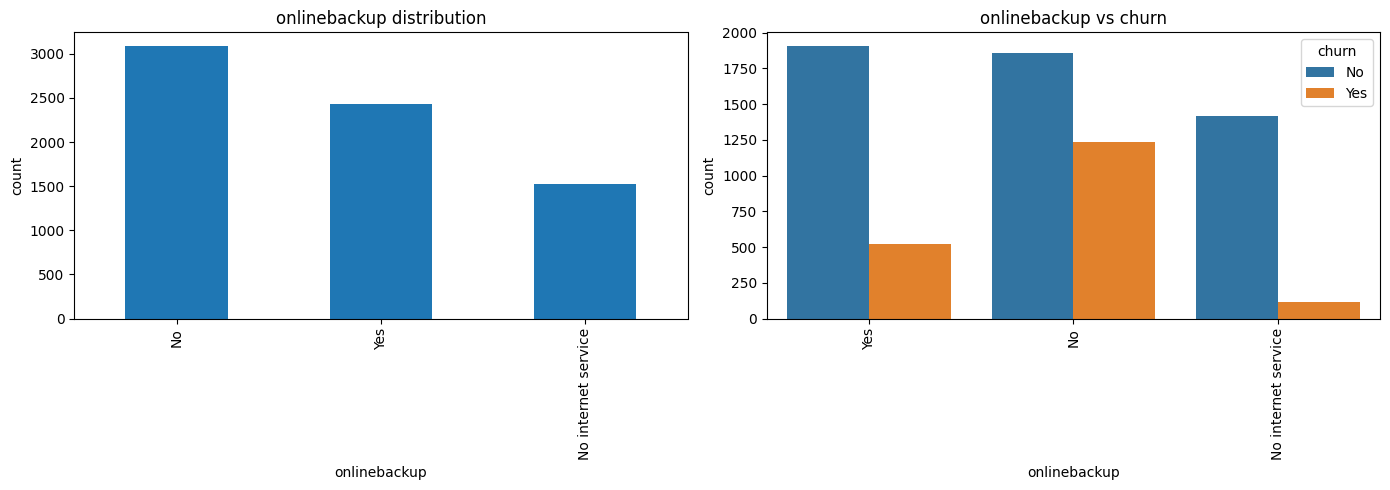

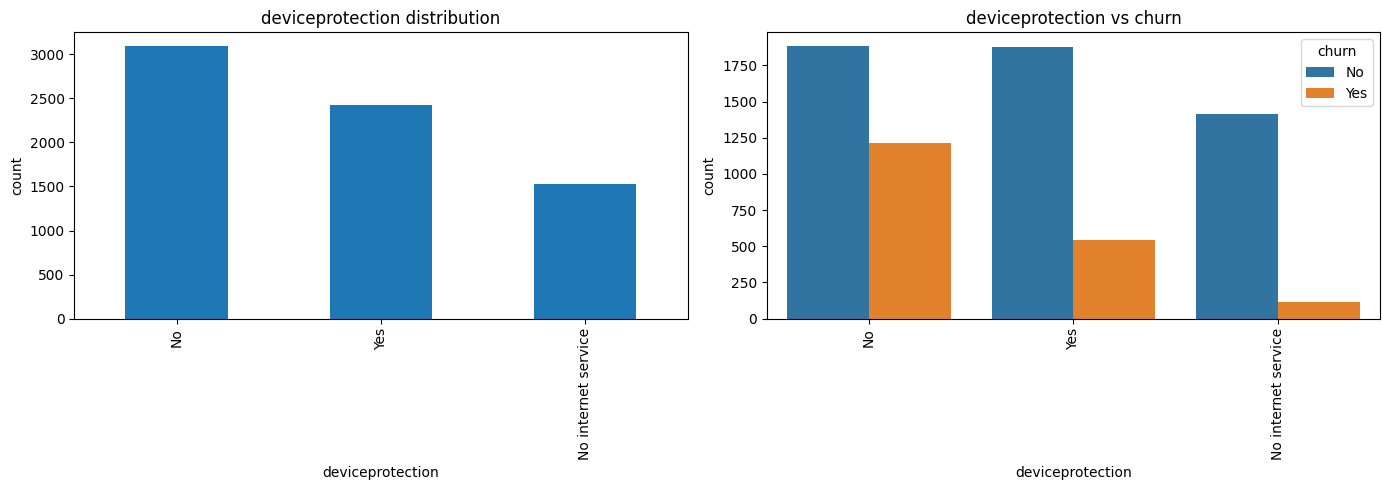

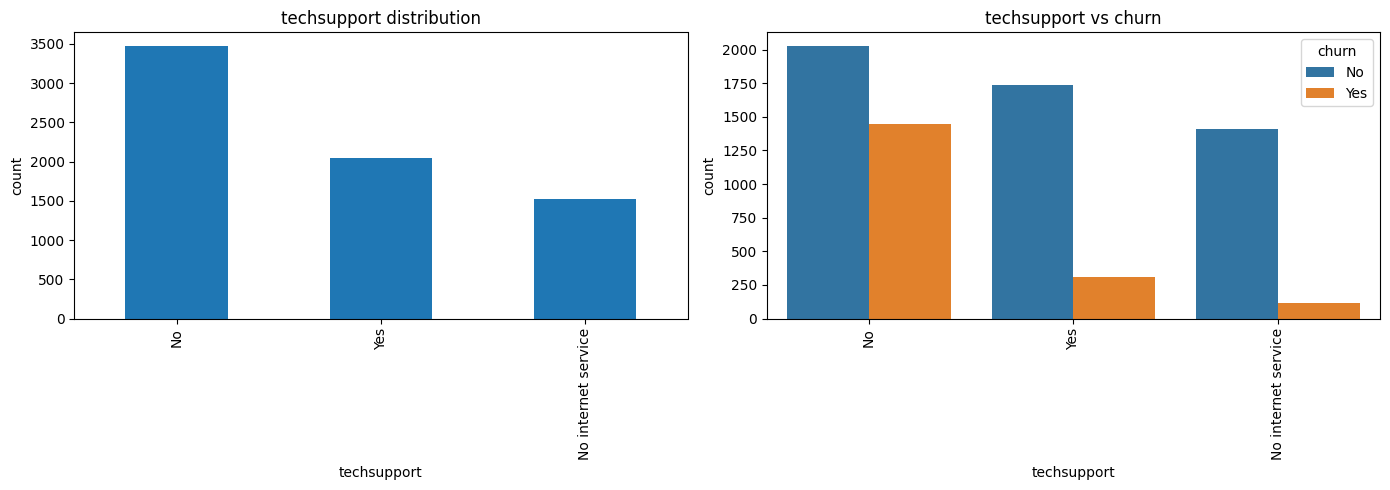

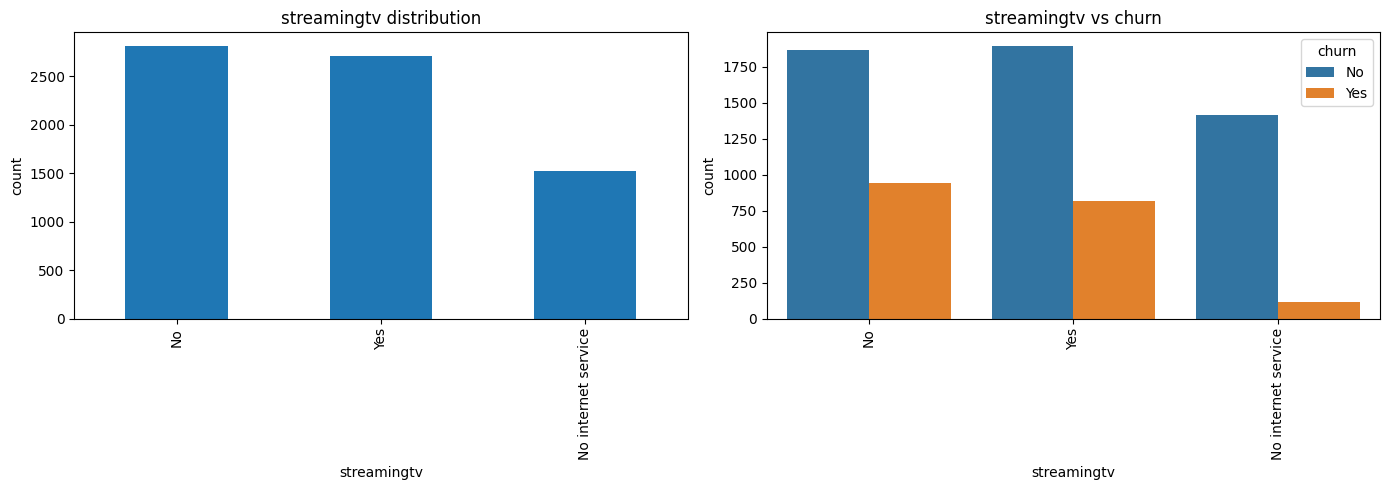

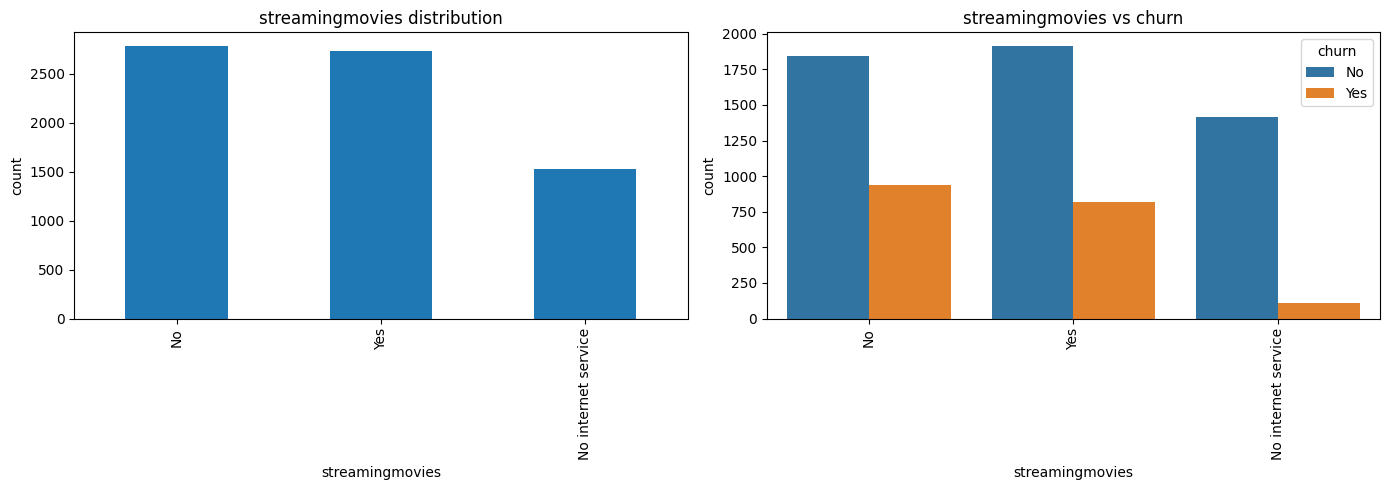

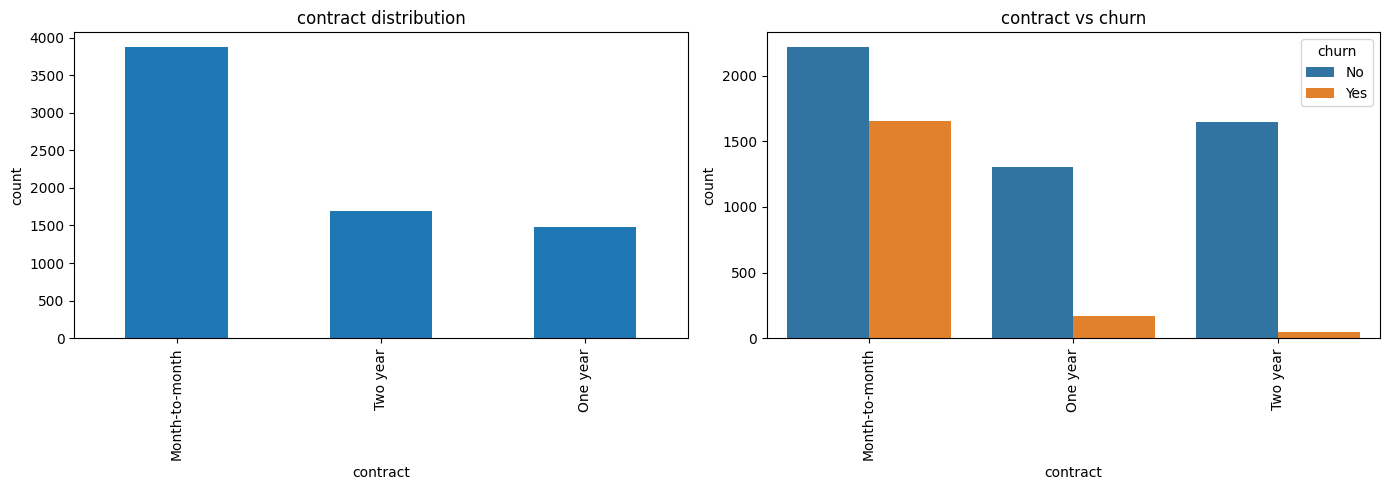

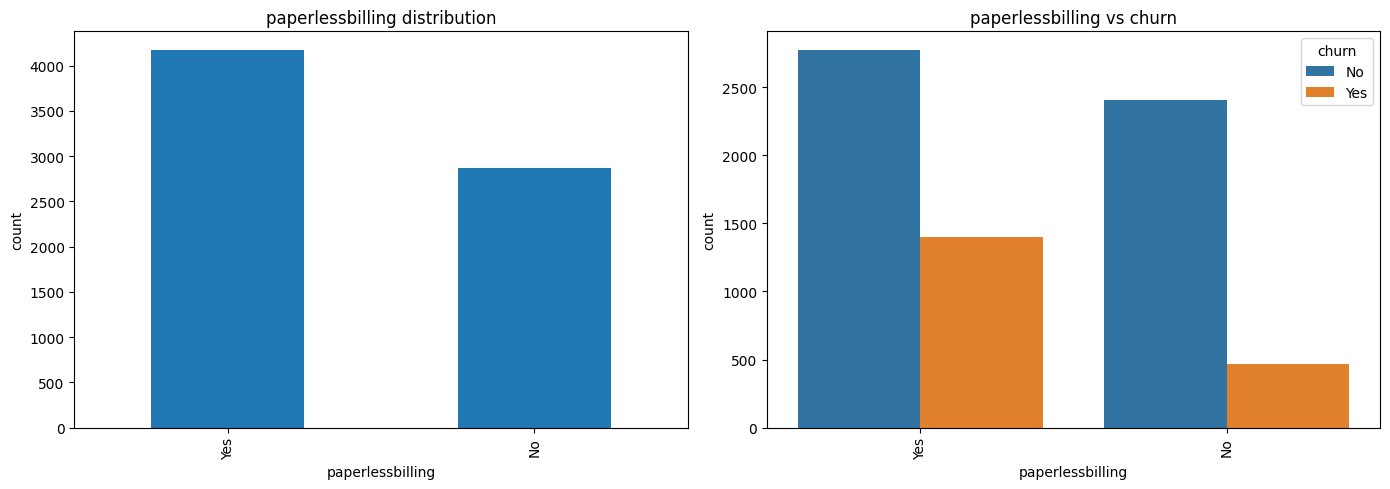

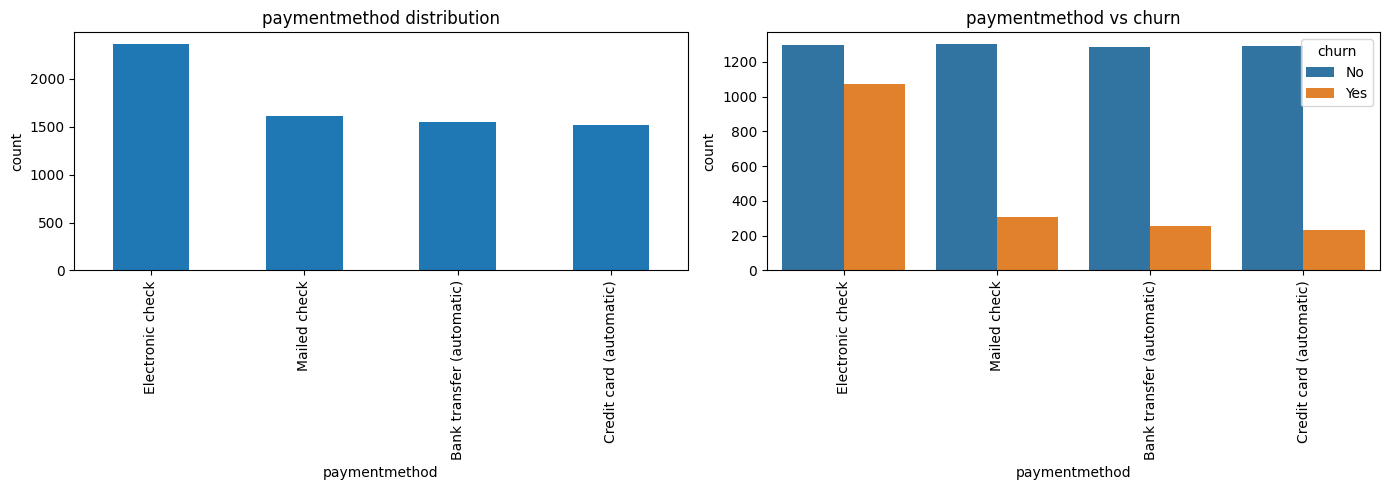

In [21]:
plot_cat_churn_pair(data_2, "churn", cat_cols)

> Insight: Customers without phone or internet services show low churn risk, while multi-line and fiber optic subscribers are more sensitive to billing and contract conditions. These groups offer high retention potential through targeted engagement.


## Feature Relationship Analysis Approach

Customer attributes are analyzed *prior to encoding*, to preserve business context and human-readable categories.  
For numeric churn drivers we use **Spearman Rank Correlation** to detect monotonic dependency trends, instead of Pearson, to avoid sensitivity to scale and outliers.

Categorical association metrics (**e.g., Cramer's V**) are planned only if deeper dependency profiling is required later for segment-level statistical justification and are not mandatory for the core modeling pipeline of this notebook.


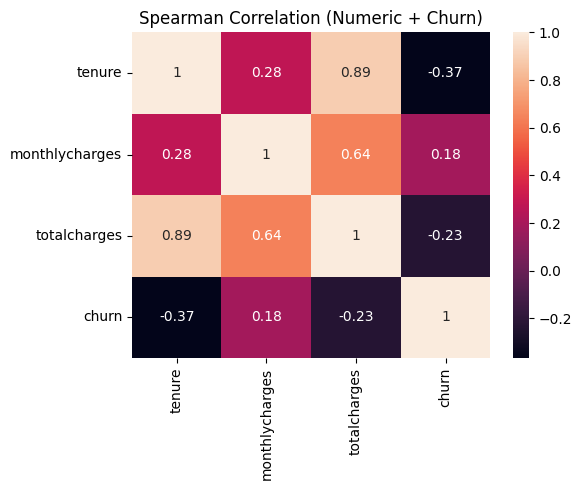

In [22]:
# convert churn to int
data_2['churn'] = (data_2['churn'].astype(str).map({'Yes': 1, 'No': 0}) .astype(float))

# select numeric features only 
num_features = ['tenure', 'monthlycharges', 'totalcharges']

# spearman matrix
corr_num = data_2[num_features + ['churn']].corr(method='spearman')

plt.figure(figsize=(6, 5))
sns.heatmap(corr_num, annot=True, ax=plt.gca())
plt.title("Spearman Correlation (Numeric + Churn)")
plt.tight_layout()
plt.show()

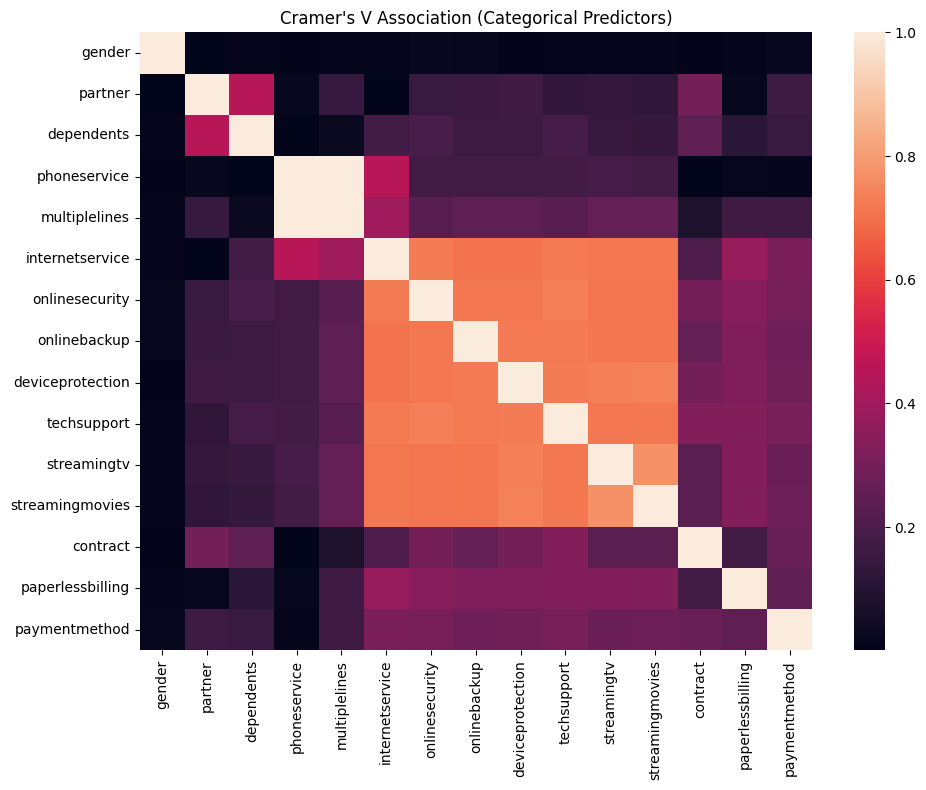

In [25]:
# categorical cramers matrix
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# identify categorical columns
cat_cols = data_2.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols = [c for c in cat_cols if c not in ['churn']]

# build Cramer's V matrix
assoc_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

for i in cat_cols:
    for j in cat_cols:
        if i == j:
            assoc_matrix.loc[i, j] = 1.0
        else:
            cm = pd.crosstab(data_2[i], data_2[j]).values
            assoc_matrix.loc[i, j] = cramers_v(cm)

assoc_matrix = assoc_matrix.astype(float)

# plot association matrix
plt.figure(figsize=(10, 8))
sns.heatmap(assoc_matrix, annot=False, ax=plt.gca())
plt.title("Cramer's V Association (Categorical Predictors)")
plt.tight_layout()
plt.show()


> **Feature conclusion based on observed relationships:**
> - **Tenure** demonstrates the strongest monotonic inverse relationship with churn (−0.37 Spearman)
> - **Contract type, payment method, and internet service** exhibit the strongest categorical association structure and customer behavior clusters
> - **Monthly charges trend upward for churned customers**, signaling billing sensitivity and retention opportunity through targeted offers
>
> These features form the analytical foundation for champion model training and retention strategy prioritization.


# Data Preprocessing & Business-Aware Encoding

To prepare the dataset for modeling, we apply transformations that balance **machine learning compatibility** with **business interpretability**.

Preprocessing objectives:
- Convert binary business flags (`Yes/No`) into numeric indicators (`1/0`)
- One-hot encode nominal multi-class categories
- Normalize billing and tenure features using min-max scaling


In [26]:
# check unique values in every column
for i in data_2.columns:
  print(f"Column '{i}' has : {data_2[i].unique()}")

Column 'gender' has : ['Female' 'Male']
Column 'seniorcitizen' has : [0 1]
Column 'partner' has : ['Yes' 'No']
Column 'dependents' has : ['No' 'Yes']
Column 'tenure' has : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Column 'phoneservice' has : ['No' 'Yes']
Column 'multiplelines' has : ['No phone service' 'No' 'Yes']
Column 'internetservice' has : ['DSL' 'Fiber optic' 'No']
Column 'onlinesecurity' has : ['No' 'Yes' 'No internet service']
Column 'onlinebackup' has : ['Yes' 'No' 'No internet service']
Column 'deviceprotection' has : ['No' 'Yes' 'No internet service']
Column 'techsupport' has : ['No' 'Yes' 'No internet service']
Column 'streamingtv' has : ['No' 'Yes' 'No internet service']
Column 'streamingmovies' has : ['No' 'Yes' 'No internet service']
Column 'contract' has : ['Month-to-month' 'One year' 'Two y

In [27]:
data_2.replace('No phone service', 'No', inplace=True)
data_2.replace('No internet service', 'No', inplace=True)

for i in data_2.columns:
  print(f"Column '{i}' has : {data_2[i].unique()}")

Column 'gender' has : ['Female' 'Male']
Column 'seniorcitizen' has : [0 1]
Column 'partner' has : ['Yes' 'No']
Column 'dependents' has : ['No' 'Yes']
Column 'tenure' has : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Column 'phoneservice' has : ['No' 'Yes']
Column 'multiplelines' has : ['No' 'Yes']
Column 'internetservice' has : ['DSL' 'Fiber optic' 'No']
Column 'onlinesecurity' has : ['No' 'Yes']
Column 'onlinebackup' has : ['Yes' 'No']
Column 'deviceprotection' has : ['No' 'Yes']
Column 'techsupport' has : ['No' 'Yes']
Column 'streamingtv' has : ['No' 'Yes']
Column 'streamingmovies' has : ['No' 'Yes']
Column 'contract' has : ['Month-to-month' 'One year' 'Two year']
Column 'paperlessbilling' has : ['Yes' 'No']
Column 'paymentmethod' has : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit

# Feature Standardization & Encoding for Churn Modeling
This preprocessing cell performs:
- Business-aware binary mapping (`Yes/No → 1/0`) for key behavioral & account-status flags
- Gender encoding (`Female = 1, Male = 0`) for ML compatibility
- One-Hot encoding of nominal attributes without ordinal meaning (`InternetService`, `Contract`, `PaymentMethod`)
- Min-Max normalization (`0–1`) of tenure and billing features for training stability and probability-score consistency


In [29]:
# list of categorical features that contain 'Yes'/'No' business labels
# these will be mapped to 1/0 for modeling purposes
cols_with_yes_no_values = [
    'partner', 'dependents', 'phoneservice', 'multiplelines',
    'onlinesecurity', 'onlinebackup', 'deviceprotection',
    'techsupport', 'streamingtv', 'streamingmovies',
    'paperlessbilling'
]

for col in cols_with_yes_no_values:
    data_2[col] = data_2[col].replace({'Yes': 1, 'No': 0})
    # validate transformation
    print(f"{col} values after mapping:", data_2[col].unique())

# encode gender as 1/0 while preserving business meaning
data_2['gender'] = data_2['gender'].replace({'Female': 1, 'Male': 0})
print("Gender values after encoding:", data_2['gender'].unique())

# One-hot encode multi-level categoricals into ML-suitable numeric columns
# drop_first=True avoids dummy variable trap in linear models
data_2 = pd.get_dummies(data=data_2, columns=['internetservice', 'contract', 'paymentmethod'], drop_first=True)

# Normalize numeric features between 0 and 1 for model stability
cols_to_scale = ['tenure', 'monthlycharges', 'totalcharges']
scaler = MinMaxScaler()
data_2[cols_to_scale] = scaler.fit_transform(data_2[cols_to_scale])

print("\nNumeric scaling applied using Min-Max normalization (0-1).")
data_2[cols_to_scale].head()

partner values after mapping: [1 0]
dependents values after mapping: [0 1]
phoneservice values after mapping: [0 1]
multiplelines values after mapping: [0 1]
onlinesecurity values after mapping: [0 1]
onlinebackup values after mapping: [1 0]
deviceprotection values after mapping: [0 1]
techsupport values after mapping: [0 1]
streamingtv values after mapping: [0 1]
streamingmovies values after mapping: [0 1]
paperlessbilling values after mapping: [1 0]
Gender values after encoding: [1 0]

Numeric scaling applied using Min-Max normalization (0-1).


,tenure,monthlycharges,totalcharges
0,0.013889,0.115423,0.003437
1,0.472222,0.385075,0.217564
2,0.027778,0.354229,0.012453
3,0.625000,0.239303,0.211951
4,0.027778,0.521891,0.017462


# Model Development for Churn Risk Classification

We now train multiple binary classifiers, optimize them using cross-validation, and evaluate business-relevant separation metrics:

- **AUROC** → ranking power  
- **KS** → separation strength for churn targeting  
- **Gini** → normalized discriminatory capability  

Champion selection will be based on highest separation & business usability.


In [30]:
# sanity check for unmapped/missing
print("NaN after map:", data_2['churn'].isnull().sum())  

# define X/y
X = data_2.drop(columns='churn')
y = data_2['churn']

# split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


NaN after map: 0
Train: (5634, 23) Test: (1409, 23)


In [31]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [32]:
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

In [33]:
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'AUROC': [],
    'KS': [],
    'Gini': []
}

In [34]:
for model_name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # basic metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)

    # Probs for ranking metrics
    if hasattr(classifier, "predict_proba"):
        y_prob = classifier.predict_proba(X_test)[:, 1]
    else:  # SVC / non-proba models
        try:
            y_prob = classifier.decision_function(X_test)
            # Normalize to 0-1
            y_prob = (y_prob - y_prob.min())/(y_prob.max() - y_prob.min())
        except:
            y_prob = None

    # AUROC
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    #KS test on model predictions
    churn_yes = y_prob[y_test == 1]
    churn_no = y_prob[y_test == 0]
    ks = ks_2samp(churn_yes, churn_no).statistic if y_prob is not None else np.nan

    # Gini
    gini = 2 * auc - 1 if not np.isnan(auc) else np.nan

    # Append to table
    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(acc)
    metrics['Precision'].append(prec)
    metrics['Recall'].append(rec)
    metrics['AUROC'].append(auc)
    metrics['KS'].append(ks)
    metrics['Gini'].append(gini)

In [36]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,Accuracy,Precision,Recall,AUROC,KS,Gini
0,Random Forest,0.792051,0.636364,0.505348,0.825798,0.510868,0.651595
1,LogisticRegression,0.801278,0.646875,0.553476,0.840732,0.516756,0.681464
2,Gradient Boosting,0.798439,0.655172,0.508021,0.842063,0.531001,0.684125


# Champion Model: Gradient Boosting

The **Gradient Boosting classifier** is selected as champion due to its superior separation metrics:

- **KS score demonstrates strong distinction between churn vs retained customers**
- **AUROC and Gini confirm excellent ranking power**
- **Recall/precision balance is suitable for retention targeting without overspending marketing budget**

This model will be serialized for deployment and inference pipeline integration.


In [ ]:
# train RF model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [38]:
X = data_2.drop(columns='churn')
y = data_2['churn']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

gb = GradientBoostingClassifier(random_state=42)

params_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(3, 15),
    'min_samples_split': randint(2, 8),
    'min_samples_leaf': randint(1, 4),
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

gb_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=params_dist,
    n_iter=7,
    cv=5,
    verbose=2,
    random_state=42,
    scoring='roc_auc'
)

gb_search.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END learning_rate=0.1, max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=171; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=171; total time=   4.2s
[CV] END learning_rate=0.1, max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=171; total time=   4.9s
[CV] END learning_rate=0.1, max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=171; total time=   3.5s
[CV] END learning_rate=0.1, max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=171; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=314; total time=   3.8s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=314; total time=   3.8s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=314; tota

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=7,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000240CEF52E90>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000240CEF50710>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000240CEF50A10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000240CDE57050>},
                   random_state=42, scoring='roc_auc', verbose=2)

In [48]:
best_gb_model = gb_search.best_estimator_

In [49]:
y_pred = best_gb_model.predict(X_test)

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)

# Predict probabilities for ranking metrics
y_prob = best_gb_model.predict_proba(X_test)[:, 1]

# Ranking quality metrics
auroc = roc_auc_score(y_test, y_prob)
gini  = 2 * auroc - 1

# KS separation between churn cohorts based on probability score
ks = ks_2samp(y_prob[y_test == 1], y_prob[y_test == 0]).statistic


In [50]:
print(f"accuracy : {accuracy:.3f}")
print(f"precision: {precision:.3f}")
print(f"recall : {recall:.3f}")
print(f"auroc : {auroc:.3f}")
print(f"ks : {ks:.3f}")
print(f"gini : {gini:.3f}")

accuracy : 0.801
precision: 0.670
recall : 0.485
auroc : 0.854
ks : 0.554
gini : 0.708


# Champion Model Selection & Performance Summary
Gradient Boosting is selected as the Champion model due to:
- Highest discriminative power (best **Gini**, **KS**, **AUROC** separation)
- Strong business interpretability
- Stable results after hyperparameter optimization
- Clear opportunity for retention strategy deployment

Final model performance:
| Metric | Score |
|--------|------|
| Accuracy | 0.801 |
| Precision | 0.670 |
| Recall | 0.485 |
| AUROC | 0.854 |
| KS | 0.554 |
| Gini | 0.708 |


In [ ]:
#  SAVE CHAMPION MODEL (Gradient Boosting)
#  The saved object is a trained classifier ready for use

import pickle

model_filename = "Churn_Champion_Model.pkl"

# Save the trained champion model
with open(model_filename, "wb") as f:
    pickle.dump(best_gb_model, f)

print(f"Champion Gradient Boosting model successfully saved as: {model_filename}")

#  Sanity check – reload model to ensure it was stored properly
with open(model_filename, "rb") as f:
    champion_model = pickle.load(f)

print("Loaded model type after save:", type(champion_model))
print("Sanity check predictions:", champion_model.predict(X_test)[:5])

#  Optional: Save full inference pipeline (scaler + model)
from sklearn.pipeline import Pipeline

churn_pipeline = Pipeline([
    ('scaler', scaler),         
    ('model', best_gb_model)   
])

with open("Churn_Pipeline.pkl", "wb") as f:
    pickle.dump(churn_pipeline, f)

print("Full scoring pipeline saved as: Churn_Pipeline.pkl")


Champion Gradient Boosting model successfully saved as: Churn_Champion_Model.pkl
Loaded model type after save: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Sanity check predictions: [1. 0. 0. 1. 0.]
Full scoring pipeline saved as: Churn_Pipeline.pkl


# Business Pitch & Retention Strategy Summary

🔹 The model allows business teams to **rank customers by churn probability** and prioritize retention initiatives.  
🔹 It isolates high-risk churn segments, enabling:

- **Contract upgrade incentives**
- **Personalized promotional offers**
- **Early engagement for new customers**
- **Support-based interventions when tech issues appear**
- **Reward & loyalty retention programs for long-tenure customers**

With this notebook completed, we now move to structuring the **business presentation storytelling narrative** for TBI stakeholders.
